# CascadeTabNet Demo Notebook
[![PWC](https://img.shields.io/endpoint.svg?url=https://paperswithcode.com/badge/cascadetabnet-an-approach-for-end-to-end/table-detection-on-icdar2013-1)](https://paperswithcode.com/sota/table-detection-on-icdar2013-1?p=cascadetabnet-an-approach-for-end-to-end)
[![PWC](https://img.shields.io/badge/PyTorch-v1.4-blue)](https://pytorch.org/)
[![PWC](https://img.shields.io/badge/%20mmdetection%20-v1.2-blue)](https://github.com/open-mmlab/mmdetection)

> **CascadeTabNet: An approach for end to end table detection and structure recognition from image-based documents**<br>
> [Devashish Prasad](https://github.com/DevashishPrasad),
> [Ayan Gadpal](https://github.com/ayangadpal),
> [Kshitij Kapadni](https://github.com/kshitijkapadni),
> [Manish Visave](https://github.com/ManishDV),
> <br>
> [Preprint Link of Paper](https://arxiv.org/abs/2004.12629)<br>
> <a href="results.pdf">Supplementary file</a> <br>
> The paper has been accepted at [CVPR 2020 Workshop on Text and Documents in the Deep Learning Era](https://cvpr2020text.wordpress.com/)<br>
> [Code Link](https://github.com/DevashishPrasad/CascadeTabNet)
<img align="right" src="imgs/CVPR Teaser.gif" />

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import cv2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Install all the prerequisite
This will take a while, Remember to **Restart Runtime** after this step is done 

In [2]:
!pip install torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -q mmcv terminaltables
!git clone --branch v1.2.0 'https://github.com/open-mmlab/mmdetection.git'
%cd "mmdetection"
!pip install -r "/content/mmdetection/requirements/optional.txt"
!python setup.py install
!python setup.py develop
!pip install -r {"requirements.txt"}
!pip install pillow==6.2.1 
!pip install mmcv==0.4.3
%cd "/content"

Looking in links: https://download.pytorch.org/whl/torch_stable.html
fatal: destination path 'mmdetection' already exists and is not an empty directory.
/content/mmdetection
running install
running bdist_egg
running egg_info
writing mmdet.egg-info/PKG-INFO
writing dependency_links to mmdet.egg-info/dependency_links.txt
writing requirements to mmdet.egg-info/requires.txt
writing top-level names to mmdet.egg-info/top_level.txt
writing manifest file 'mmdet.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
copying mmdet/version.py -> build/lib.linux-x86_64-3.7/mmdet
running build_ext
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mmdet
creating build/bdist.linux-x86_64/egg/mmdet/apis
copying build/lib.linux-x86_64-3.7/mmdet/apis/test.py -> build/bdist.linux-x86_64/egg/mmdet/apis
copying build/lib.linux-x86_64-3.7/mmdet/apis/train.py -> build/bdist.linux-x86_64/egg/mmdet/apis
copying build/lib.linu

## 2. Clone the Repository 
We will be using "ICDAR 19 (Track B2 Modern) table structure recognition" for demo

In [3]:
!git clone https://github.com/DevashishPrasad/CascadeTabNet.git

fatal: destination path 'CascadeTabNet' already exists and is not an empty directory.


## 3. Download the Pretrained Model



In [4]:
!gdown "https://drive.google.com/u/0/uc?id=1-QieHkR1Q7CXuBu4fp3rYrvDG9j26eFT"

Downloading...
From: https://drive.google.com/u/0/uc?id=1-QieHkR1Q7CXuBu4fp3rYrvDG9j26eFT
To: /content/epoch_36.pth
664MB [00:10, 61.3MB/s]


## 4. Run the Predictions

In [5]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
import cv2
import matplotlib.pyplot as plt
# Load model
config_file = '/content/CascadeTabNet/Config/cascade_mask_rcnn_hrnetv2p_w32_20e.py'
checkpoint_file = '/content/epoch_36.pth'
model = init_detector(config_file, checkpoint_file, device='cuda:0')

# # Test a single image 
# img = "/content/drive/MyDrive/CV-OCR/test cascade tabnet/test1.png"

# # Run Inference
# result = inference_detector(model, img)

# # Visualization results
# show_result_pyplot(img, result,('Bordered', 'cell', 'Borderless'), score_thr=0.8)

In [13]:
def invert_img(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.bilateralFilter(img_gray, 9, 15, 15) 
    not_image = cv2.bitwise_not(img_gray)
    img_bin = cv2.adaptiveThreshold(not_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, -4)
    not_image = cv2.bitwise_not(img_bin)
    return not_image

In [45]:
def invert(img):
    '''
    return binary image with white lines, text and black background
    '''
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.bilateralFilter(img_gray, 9, 15, 15) 
    not_image = cv2.bitwise_not(img_gray)
    img_bin = cv2.adaptiveThreshold(not_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, -4)
    return img_bin
def resize_image(img):
    h, w = img.shape[:2]
    max_hw = max(h, w)
    scale = 2048 / max_hw
    img = cv2.resize(img, None, fx = scale, fy = scale)
    return img
def get_vertical_lines(img_bin):
    '''
    return vertical lines
    '''
    kernel_length_v = 10
    #create kernel
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length_v))
    im_temp1 = cv2.erode(img_bin, vertical_kernel, iterations=3)
    vertical_lines_img = cv2.dilate(im_temp1, vertical_kernel, iterations=3)
    return vertical_lines_img
def get_horizontal_lines(img_bin):
    '''
    return horizontal lines
    '''
    kernel_length_h = 20
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length_h, 1))
    im_temp2 = cv2.erode(img_bin, horizontal_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(im_temp2, horizontal_kernel, iterations=3)
    return horizontal_lines_img
def joints_ver_hor_lines(vertical_lines_img, horizontal_lines_img):
    '''
    return joints vertical and horizontal lines
    '''
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    ## add weight thuc hien viec cong hai anh theo weights
    table_segment = cv2.addWeighted(vertical_lines_img, 0.5, horizontal_lines_img, 0.5, 0.0)
    ## thuc hien dao nguoc anh va lam nho nhung vung mau trang ==> duong net mau den se hien ra to hon
    table_segment = cv2.erode(cv2.bitwise_not(table_segment), kernel, iterations=2)
    thresh, table_segment = cv2.threshold(table_segment, 0, 255, cv2.THRESH_OTSU)
    plt.imshow(table_segment, 'gray')
    return cv2.bitwise_not(table_segment)
def table_segment(contours):
    '''
    return bounding box covers all tables
    '''
    list_area = []
    list_contour = []
    for c in contours:
        area = cv2.contourArea(c)
        if area > 50000:
            list_contour.append(c)
    x_min = 10000
    y_min = 10000
    x_max = 0
    y_max = 0
    for idx, c in enumerate(list_contour):
        xc, yc, wc, hc = cv2.boundingRect(c)
        if xc < x_min:
            x_min = xc
        if yc < y_min:
            y_min = yc
        if (xc + wc) > x_max:
            x_max = xc + wc
        if (yc + hc) > y_max:
            y_max = yc + hc
    return x_min, y_min, x_max, y_max
def extract_line_boxes(horizontal_lines, vertical_lines):
    '''
    return bounding boxes of lines
    '''
    image_h, image_w = horizontal_lines.shape[:2]
    contours_h, _ = cv2.findContours(horizontal_lines.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    rects_h = [cv2.boundingRect(c) for c in contours_h]
    hori_boxes = sorted(rects_h, key=lambda k: [k[1], k[0]])
    contours_v, _ = cv2.findContours(vertical_lines.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    rects_v = [cv2.boundingRect(c) for c in contours_v]
    ver_boxes = sorted(rects_v, key=lambda k: [k[0], k[1]])
    if len(hori_boxes) == 0 or len(ver_boxes) == 0:
        hori_extend_boxes, ver_extend_boxes = hori_boxes, ver_boxes
    else:
        hori_extend_boxes, ver_extend_boxes = extend_boxes(hori_boxes, ver_boxes, image_h, image_w, scale = 1)

    return hori_extend_boxes, ver_extend_boxes
def extend_boxes(horizontal_boxes, vertical_boxes, image_h, image_w, scale = 1):
    INTERSECT_THRESHOLD = 15   
    # # Create new horizontal lines to connect the top of the vertical lines
    # # horizontal_boxes = sorted(horizontal_boxes, key=lambda k: [k[1], k[0]], reverse=True)
    # vertical_boxes = sorted(vertical_boxes, key=lambda k: [k[0], k[1]])
    extended_horizontal_boxes = horizontal_boxes.copy()
    extended_vertical_boxes = vertical_boxes.copy()

    #####################################
    # Create new horizontal lines to connect the bottom of the vertical lines
    horizontal_boxes = sorted(horizontal_boxes, key=lambda k: [k[1], k[0]])
    vertical_boxes = sorted(vertical_boxes, key=lambda k: [k[0], k[1]])
    bottom_horizontal = horizontal_boxes[-1]
    most_left_ver = vertical_boxes[0]
    most_right_ver = vertical_boxes[-1]
    check_bottom_hori = False
    for i in range(len(horizontal_boxes)):
        x1, y1, h1, w1 = horizontal_boxes[i]
        if abs(y1 - max(most_left_ver[1] + most_left_ver[3], most_right_ver[1] + most_right_ver[3])) < INTERSECT_THRESHOLD:
            check_bottom_hori = True
            break
    if not check_bottom_hori:
        y_h = min(most_left_ver[1] + most_left_ver[3], most_right_ver[1] + most_right_ver[3])
        if y_h <= image_h:
            y_h = y_h - 5
        extended_horizontal_boxes.append(combine_point(most_left_ver[0], y_h, most_right_ver[0], y_h))
    
    ##############################

    # create horizontal lines to connect 2 horizontal lines
    horizontal_boxes = sorted(horizontal_boxes, key=lambda k: [k[1], k[0]])
    for i in range(len(horizontal_boxes)-1):
        box1 = horizontal_boxes[i]
        x1, y1, w1, h1 = box1
        for j in range(i+1, len(horizontal_boxes)):
            box2 = horizontal_boxes[j]
            x2, y2, w2, h2 = box2
            if abs(x2 - x1 - w1) < INTERSECT_THRESHOLD*3  and abs(y2 - y1) < 5:
                extended_horizontal_boxes.append(combine_point(x1 + w1, y1, x2, y2))
                break
    
    ###################################

    #create vertical lines to connect 2 vertical lines
    for i in range(len(vertical_boxes)-1):
        box1 = vertical_boxes[i]
        x1, y1, w1, h1 = box1
        for j in range(i+1, len(vertical_boxes)):
            box2 = vertical_boxes[j]
            x2, y2, w2, h2 = box2
            if abs(y2 - y1 - h1) < INTERSECT_THRESHOLD*3 and abs (x2 - x1) < 15:
                extended_vertical_boxes.append(combine_point(x1, y1, x1, y2))
                break

    ###################################

    # extend horizontal lines till meet vertical lines:
    ## left
    for i in range(len(horizontal_boxes)):
        x1, y1, w1, h1 = horizontal_boxes[i]
        ## left
        if x1 - most_left_ver[0] < INTERSECT_THRESHOLD*2 and w1 > 100:
            extended_horizontal_boxes.append(combine_point(most_left_ver[0], y1, x1, y1))
            break
        ## right
        if most_right_ver[0] - x1 < INTERSECT_THRESHOLD*2 and w1 > 100:
            extended_horizontal_boxes.append(combine_point(x1, y1, most_right_ver[0], y1))
            break

    vertical_boxes = sorted(extended_vertical_boxes, key=lambda k: [k[0], k[1]])
    horizontal_boxes = sorted(extended_horizontal_boxes, key=lambda k: [k[1], k[0]])

    return horizontal_boxes, vertical_boxes
def combine_box(box_i, box_j):
    x_min = min(box_i[0], box_j[0])
    y_min = min(box_i[1], box_j[1])
    x_max = max(box_i[0] + box_i[2], box_j[0] + box_j[2])
    y_max = max(box_i[1] + box_i[3], box_j[1] + box_j[3])
    box = [x_min, y_min, x_max - x_min, y_max - y_min]
    return box

def combine_point(x1, y1, x2, y2):
    x_min = min(x1, x2)
    y_min = min(y1, y2)
    x_max = max(x1, x2)
    y_max = max(y1, y2)
    w = x_max - x_min if x_max - x_min > 0 else 1
    h = y_max - y_min if y_max - y_min > 0 else 1
    box = [x_min, y_min, w, h]
    return box

def draw_cell_lines(cell_img, horizontal_boxes, vertical_boxes):
    '''
    return table image
    '''
    #Draw horizontal lines
    for box in horizontal_boxes:
        x,y,w,h = box
        start_x = x
        start_y = int(y+h/2)
        end_x = x+w
        end_y = start_y
        cell_img = cv2.line(cell_img, (start_x, start_y), (end_x, end_y), (255,255,255), 1)

    #Draw vertical lines
    for box in vertical_boxes:
        x,y,w,h = box
        start_x = int(x+w/2)
        start_y = y
        end_x = start_x
        end_y = y+h
        cell_img = cv2.line(cell_img, (start_x, start_y), (end_x, end_y), (255,255,255), 1)
    return cell_img

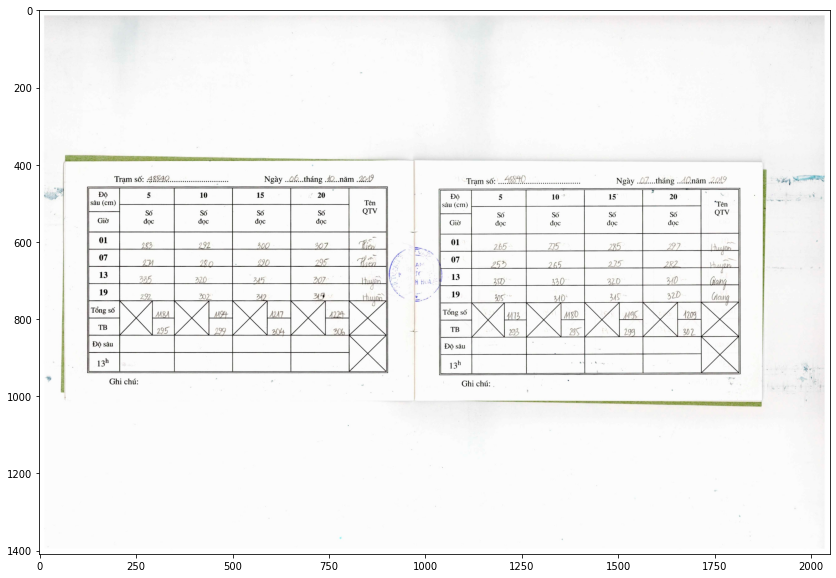

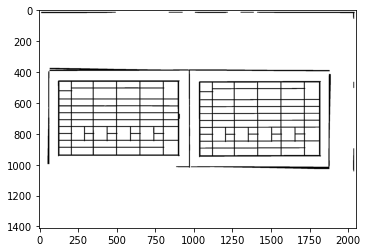

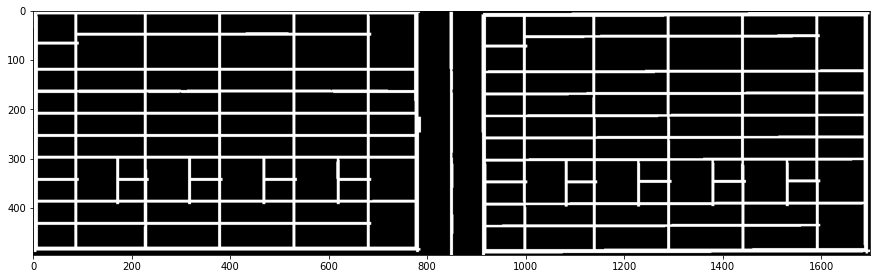

In [31]:
img = "/content/drive/MyDrive/CV-OCR/KTTV/4_SKT3.Thanh Hoa.pdf.jpg"
img = cv2.imread(img)
img = resize_image(img)
img_not = invert(img)
plt.figure(figsize=(15,10))
plt.imshow(img)
plt.show()
# plt.figure(figsize=(15,10))
# plt.imshow(img_not, 'gray')
# plt.show()
vertical_lines = get_vertical_lines(img_not)
horizontal_lines = get_horizontal_lines(img_not)
ver_hor_lines = joints_ver_hor_lines(vertical_lines, horizontal_lines)
plt.figure(figsize=(15,10))
# plt.imshow(ver_hor_lines)
# plt.show()
cnts = cv2.findContours(ver_hor_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
c = sorted(cnts, key=cv2.contourArea, reverse=True)
x_tl, y_tl, x_br, y_br = table_segment(c)
segmented_table = ver_hor_lines[y_tl:y_br, x_tl:x_br]
x_crop = x_tl
y_crop = y_tl
plt.imshow(segmented_table, 'gray')
plt.show()

In [32]:
area_contours = []
cnts = cv2.findContours(segmented_table, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
area_image = segmented_table.shape[0]*segmented_table.shape[1]
if len(cnts) < 1:
    pass
elif len(cnts) == 1:
    area_contours.append(cv2.boundingRect(cnts[0]))
else:
    for cnt in cnts:
        x,y,w,h = cv2.boundingRect(cnt)
        rect_area = w*h
        ratio = rect_area/area_image
        if ratio > 0.01:
            area_contours.append((x,y,w,h))
    area_contours = sorted(area_contours, key = lambda k: [k[0], k[1]])


0 0 788 490


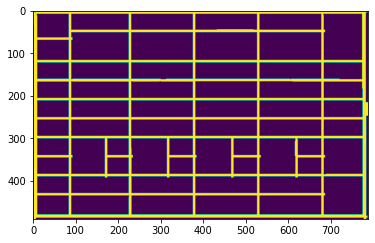

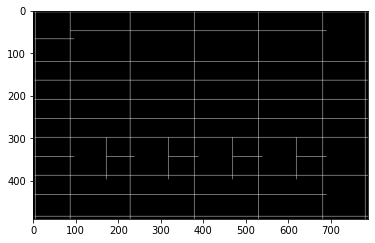

911 4 789 492


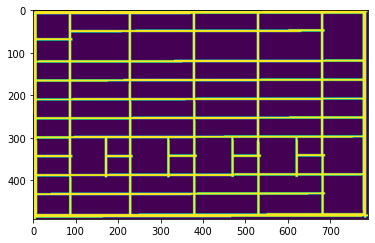

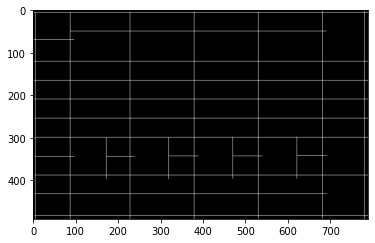

In [47]:
for contour in area_contours:
        x, y, w, h = contour
        print(x, y, w, h)
        table_bw = segmented_table[y:y+h, x:x+w]
        plt.imshow(table_bw)
        plt.show()
        vert = get_vertical_lines(table_bw)
        hori = get_horizontal_lines(table_bw)
        hori_boxes, vert_boxes = extract_line_boxes(hori, vert)
        # Create new black image
        cell_image = np.zeros(table_bw.shape,dtype=np.uint8)
        # Draw lines
        cell_image = draw_cell_lines(cell_image, hori_boxes, vert_boxes)
        plt.imshow(cell_image, 'gray')
        plt.show()
        margin_x = x_crop + x
        margin_y = y_crop + y
        contours, hierarchy = cv2.findContours(table_bw, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        list_cells, img = find_cell_bbox(contours, hierarchy, margin_x, margin_y, img)
        if len(list_cells) == 0:
            continue
        row_dict, col_dict = get_row_col_dict(list_cells)
        sheet_cell_dict, list_sheet_merge = get_sheet_cell_and_merge(list_cells, row_dict, col_dict, img)
        if count > 0:
            sheet = wb.create_sheet("Sheet {}".format(count))
        else:
            sheet = ws1
        sheet = write_sheet(sheet, sheet_cell_dict, list_sheet_merge)
        count+=1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


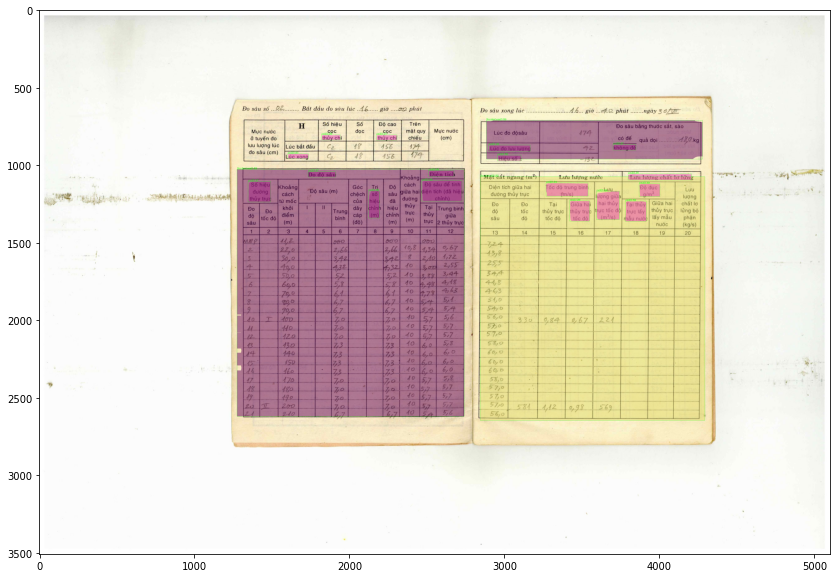

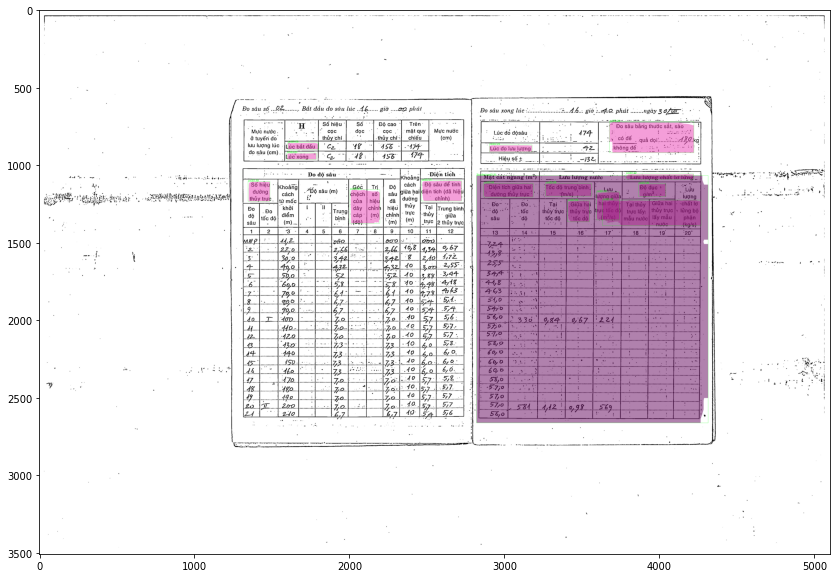

In [ ]:

img = "/content/drive/MyDrive/CV-OCR/KTTV/2_Qtrieu.pdf.jpg"
img = cv2.imread(img)
# img = cv2.rotate(cv2.imread(img), cv2.cv2.ROTATE_90_CLOCKWISE) 
# Run Inference
result = inference_detector(model, img)

# Visualization results
show_result_pyplot(img, result,('Bordered', 'cell', 'Borderless'), score_thr=0.85)

# 
#Invert to binary
img = invert_img(cv2.imread("/content/drive/MyDrive/CV-OCR/KTTV/2_Qtrieu.pdf.jpg"))
# img = cv2.rotate(img, cv2.cv2.ROTATE_90_CLOCKWISE)
img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
# Run Inference
result = inference_detector(model, img)

# Visualization results
show_result_pyplot(img, result,('Bordered', 'cell', 'Borderless'), score_thr=0.885)

In [48]:
result[0][2][0][4]

0.92976123

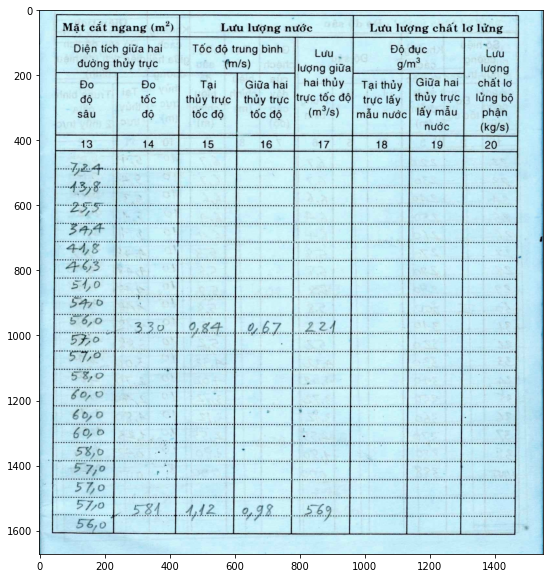

In [ ]:
crop_img = img[result[0][0][2][1].astype(np.int32)-50:result[0][0][2][3].astype(np.int32)+50, 
               result[0][0][2][0].astype(np.int32)-50:result[0][0][2][2].astype(np.int32)+50]
plt.figure(figsize=(20,10))
plt.imshow(crop_img)

In [ ]:
result[0][2][1][4]

0.88641757

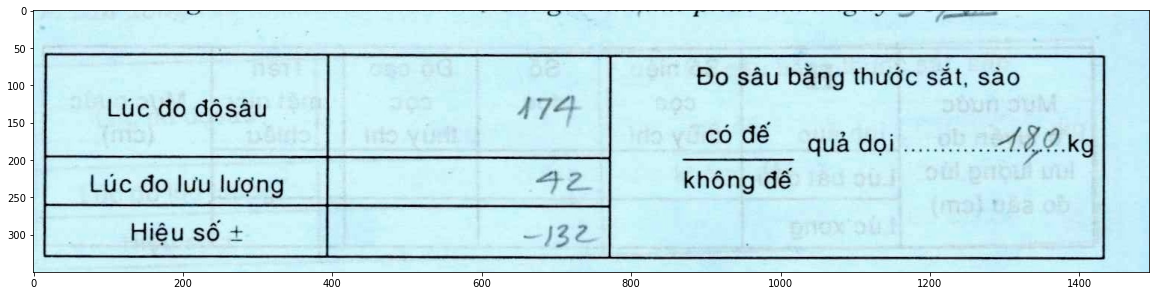

In [ ]:
crop_img = img[result[0][2][1][1].astype(np.int32)-50:result[0][2][1][3].astype(np.int32)+50, 
               result[0][2][1][0].astype(np.int32)-50:result[0][2][1][2].astype(np.int32)+50]
plt.figure(figsize=(20,10))
plt.imshow(crop_img)

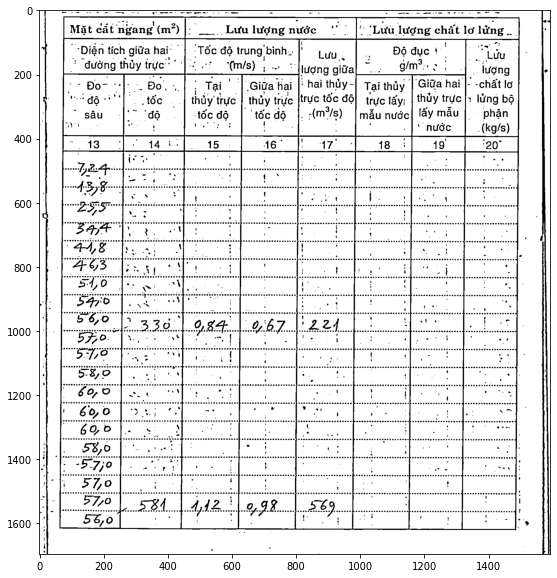

In [ ]:
crop_img = img[result[0][2][0][1].astype(np.int32)-50:result[0][2][0][3].astype(np.int32)+50, 
               result[0][2][0][0].astype(np.int32)-50:result[0][2][0][2].astype(np.int32)+50]
plt.figure(figsize=(20,10))
plt.imshow(crop_img)

In [ ]:
labels = [
    np.full(bbox.shape[0], i, dtype=np.int32)
    for i, bbox in enumerate(bbox_result)
]
print(np.concatenate(labels))

[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2]


In [ ]:
print((result[0][0][0][1]))

1029.8391


In [8]:
# Read the list of imagge directory
import os
img_path = []
for _file in os.listdir('/content/drive/MyDrive/CV-OCR/KTTV'):
    img_path.append(os.path.join('/content/drive/MyDrive/CV-OCR/KTTV/', _file))
print(img_path)

['/content/drive/MyDrive/CV-OCR/KTTV/3_CBtrieu.pdf.jpg', '/content/drive/MyDrive/CV-OCR/KTTV/6_CBtrieu.pdf.jpg', '/content/drive/MyDrive/CV-OCR/KTTV/7_CBtrieu.pdf.jpg', '/content/drive/MyDrive/CV-OCR/KTTV/8_CBtrieu.pdf.jpg', '/content/drive/MyDrive/CV-OCR/KTTV/10_CBtrieu.pdf.jpg', '/content/drive/MyDrive/CV-OCR/KTTV/11_CBtrieu.pdf.jpg', '/content/drive/MyDrive/CV-OCR/KTTV/12_CBtrieu.pdf.jpg', '/content/drive/MyDrive/CV-OCR/KTTV/1_CBngot.pdf.jpg', '/content/drive/MyDrive/CV-OCR/KTTV/7_CBngot.pdf.jpg', '/content/drive/MyDrive/CV-OCR/KTTV/8_CBngot.pdf.jpg', '/content/drive/MyDrive/CV-OCR/KTTV/9_CBngot.pdf.jpg', '/content/drive/MyDrive/CV-OCR/KTTV/10_CBngot.pdf.jpg', '/content/drive/MyDrive/CV-OCR/KTTV/11_CBngot.pdf.jpg', '/content/drive/MyDrive/CV-OCR/KTTV/12_CBngot.pdf.jpg', '/content/drive/MyDrive/CV-OCR/KTTV/13_CBngot.pdf.jpg', '/content/drive/MyDrive/CV-OCR/KTTV/14_CBngot.pdf.jpg', '/content/drive/MyDrive/CV-OCR/KTTV/15_CBngot.pdf.jpg', '/content/drive/MyDrive/CV-OCR/KTTV/16_CBngot.pd

In [7]:
for i, img in enumerate(img_path):
    
    img = cv2.imread(img)
    # Run Inference
    result = inference_detector(model, img)
    # Visualization results
    show_result_pyplot(img, result,('Bordered', 'cell', 'Borderless'), score_thr=0.8)

Output hidden; open in https://colab.research.google.com to view.

In [29]:
for i, img in enumerate(img_path[0:50]):
    
    img = cv2.imread(img)
    # Run Inference
    result = inference_detector(model, img)
    # Visualization results
    show_result_pyplot(img, result,('Bordered', 'cell', 'Borderless'), score_thr=0.8)

    #Invert to binary
    img = invert_img(cv2.imread(img_path[i]))
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    # Run Inference
    result = inference_detector(model, img)

    # Visualization results
    show_result_pyplot(img, result,('Bordered', 'cell', 'Borderless'), score_thr=0.8)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i, img in enumerate(img_path[50:]):
    
    img = cv2.imread(img)
    # Run Inference
    result = inference_detector(model, img)
    # Visualization results
    show_result_pyplot(img, result,('Bordered', 'cell', 'Borderless'), score_thr=0.8)

    #Invert to binary
    img = invert_img(cv2.imread(img_path[i]))
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    # Run Inference
    result = inference_detector(model, img)

    # Visualization results
    show_result_pyplot(img, result,('Bordered', 'cell', 'Borderless'), score_thr=0.8)


**Note :** If you are getting "no module name mmdet" error, Please Restart the runtime by pressing "Crtl+M" OR going to the runtime (5th option, top left) and selecting Restart Runtime.

After this, use TSR postprocessing for best result

# Cite us
If you find this work useful for your research, please cite our paper:

```
@misc{ cascadetabnet2020,
    title={CascadeTabNet: An approach for end to end table detection and structure recognition from image-based documents},
    author={Devashish Prasad and Ayan Gadpal and Kshitij Kapadni and Manish Visave and Kavita Sultanpure},
    year={2020},
    eprint={2004.12629},
    archivePrefix={arXiv},
    primaryClass={cs.CV}
}
```
